Download the support file for IS computation.

In [ ]:
from google.colab import auth
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')
import io
import os
from googleapiclient.http import MediaIoBaseDownload
def download_file(fn, file_id):
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()
    downloaded.seek(0)
    folder = fn.split('/')
    if len(folder) > 1:
        os.makedirs(folder[0], exist_ok=True)
    with open(fn, 'wb') as f:
        f.write(downloaded.read())
id_to_fn = {
'1z-3wIa4MzQp2fHHn2_1v1ZuI8sYKXrTw': 'inception_score.py',
'1ijo3v_Y-XrV8ytpWRey9PvHy_NV9cTBE': 'test_case_VAE.zip',
'1FZyHINMFqELoTjWUHSwM3krMF1bH3ROV': 'test_case_GAN.zip'
}
# download all files into the vm
for fid, fn in id_to_fn.items():
    print("Downloading %s from %s" % (fn, fid))
    download_file(fn, fid)

HttpError: ignored

In [ ]:
! unzip -q test_case_VAE.zip
! unzip -q test_case_GAN.zip

# VAE
### Load data for part 1.1 VAE


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from torch.optim.lr_scheduler import StepLR
import torchvision.utils as vutils
from torch.utils.data import DataLoader, TensorDataset
from scipy import linalg
from scipy.stats import entropy
import tqdm
import cv2

# FashionMNIST Dataset
train_dataset = datasets.FashionMNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.FashionMNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_batch_size = 100
test_batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=False)

## Model Definition (TODO)

In [ ]:
class VAE(torch.nn.Module):
  def __init__(self, zdim):
    super(VAE,self).__init__()

    self.input_dim = 784
    self.hidden_dim = 400
    self.latent_dim = zdim

    # Encoder layers
    self.fc_encoder = nn.Linear(self.input_dim, self.hidden_dim)
    self.fc_mean = nn.Linear(self.hidden_dim, self.latent_dim)
    self.fc_log_var = nn.Linear(self.hidden_dim, self.latent_dim)

    # Decoder layers
    self.fc_decoder_hidden = nn.Linear(self.latent_dim, self.hidden_dim)
    self.fc_decoder_out = nn.Linear(self.hidden_dim, self.input_dim)

  def encode(self, X):
    # Encoder network
    hidden = F.relu(self.fc_encoder(X))
    mean = self.fc_mean(hidden)
    log_var = self.fc_log_var(hidden)
    return mean, log_var

  def decode(self, X):
    # Decoder network
    hidden = F.relu(self.fc_decoder_hidden(X))
    return torch.sigmoid(self.fc_decoder_out(hidden))

  def reparameterization(self, mean, log_var):
    # Reparameterization trick
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    z = mean + eps * std
    return z

  def forward(self, X):
    X = X.view(-1,784)
    mean, log_var = self.encode(X)
    z = self.reparameterization(mean, log_var)
    return self.decode(z), mean, log_var



# reparameterization's output is dynamic, for the test case, we use a fixed eps
# and all the intermediate result is provided.
# You could use these values to check if you get the final output z correct.
# Or you could add eps to the input when testing the reparameterization module.
# (warm reminder: don't forget to change back, cause the dynamic reparameterization is the key to VAE)

# TEST YOUR REPARAMETRIZATION FUNCTION with the values below
testcase_mean = torch.load('test_case_VAE/mean.pt')
testcase_log_var = torch.load('test_case_VAE/log_var.pt')
# check std
testcase_std = torch.load('test_case_VAE/std.pt')
# Since epsilon is random, use the deterministic value of epsilon provided below
testcase_eps = torch.load('test_case_VAE/eps.pt')
testcase_z = torch.load('test_case_VAE/z.pt' )


FileNotFoundError: ignored

## VAE Train

### VAE Reconstruction Evaluation
For this reconstruction evaluation module, need to integrate into training procedure.

In [ ]:
# Reconstruction error module
def reconstruction_error(model, test_loader):
    '''
    Argms:
    Input:
        model: VAE model
        test_loader: Fashion-MNIST test_loader
    Output:
        avg_err: MSE
    '''
    # set model to eval
    ##################
    model.eval()
    ##################
    # Initialize MSE Loss(use reduction='sum')
    loss = nn.MSELoss(reduction='sum')
    recon_err = 0
    idx_counter = 0
    for i, (data,_) in enumerate(test_loader):
        data = data.to(device)
        # feed forward data to VAE
        output, mean, log_var = model.forward(data)

        idx_counter+=data.shape[0] # sum up the number of images in test_loader

        # flatten the reconstruction output
        # accumulate the MSELoss acrossing the whole test set
        recon_err += loss(output.view(-1), data.view(-1))

    avg_err = recon_err/idx_counter
    return avg_err

### Reconstruction error + KL divergence losses in VAE (TODO)

In [ ]:
# Return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    '''
    Compute reconstruction loss and KL divergence loss mentioned in pdf handout
    '''

    bce_loss = nn.BCELoss(reduction='sum')
    BCE = bce_loss(recon_x.view(-1), x.view(-1))

    KLD = 0.5 * torch.sum(torch.exp(log_var) + mu**2 - 1 - log_var)

    totalloss = BCE + KLD

    return totalloss


#####################################################
# TEST CASE FOR VAE LOSS
#####################################################
testcase_loss_recon_x = torch.load('test_case_VAE/loss_recon_x.pt')
testcase_loss_x = torch.load('test_case_VAE/loss_x.pt')
testcase_loss_mu = torch.load('test_case_VAE/loss_mu.pt')
testcase_loss_log_var = torch.load('test_case_VAE/loss_log_var.pt')
testcase_loss_totalloss = torch.load('test_case_VAE/loss_totalloss.pt')

loss = loss_function(testcase_loss_recon_x, testcase_loss_x, testcase_loss_mu, testcase_loss_log_var)
print("test case loss value:", testcase_loss_totalloss.item())
print("computed loss value:", loss.item())


test case loss value: 1426.35888671875
computed loss value: 1426.35888671875


### VAE Training

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: 0 LR: [0.001]
Train Epoch: 1 0% 	Loss: 548.984766 	Recon_err: 127.5504379272461
Train Epoch: 1 17% 	Loss: 284.608203 	Recon_err: 28.17443084716797
Train Epoch: 1 33% 	Loss: 271.521777 	Recon_err: 21.5369815826416
Train Epoch: 1 50% 	Loss: 272.439395 	Recon_err: 19.98406410217285
Train Epoch: 1 67% 	Loss: 261.210918 	Recon_err: 19.0887393951416
Train Epoch: 1 83% 	Loss: 271.263789 	Recon_err: 18.661020278930664
Epoch: 1 Train loss: 273.8529
Epoch: 1 LR: [0.001]
Train Epoch: 2 0% 	Loss: 259.677852 	Recon_err: 18.38991355895996
Train Epoch: 2 17% 	Loss: 256.875703 	Recon_err: 17.78801155090332
Train Epoch: 2 33% 	Loss: 253.525801 	Recon_err: 17.714088439941406
Train Epoch: 2 50% 	Loss: 251.652441 	Recon_err: 17.431671142578125
Train Epoch: 2 67% 	Loss: 253.008164 	Recon_err: 17.20221710205078
Train Epoch: 2 83% 	Loss: 243.553223 	Recon_err: 17.390531539916992
Epoch: 2 Train loss: 252.3377
Epoch: 2 LR: [0.001]
Train Epoch: 3 0% 	Loss: 246.374238 	Recon_err: 16.954538345336914
Train 

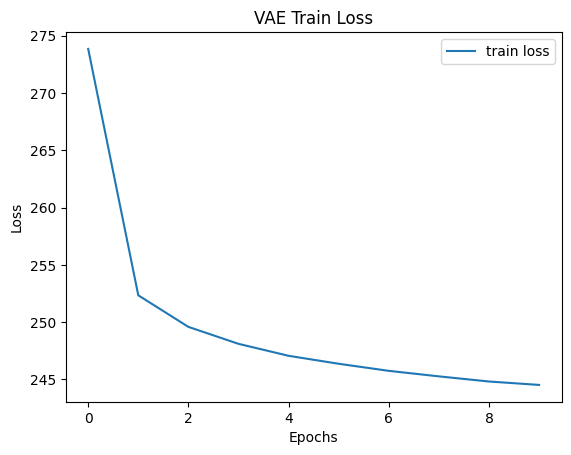

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Z dimension
ZDIM = 5

#Initialize VAE
vae = VAE(ZDIM).to(device)
#Initialize optimizer
optimizer = optim.Adam(vae.parameters(), lr = 1e-3)
#Initialize scheduler(optional)
scheduler = StepLR(optimizer, step_size=10, gamma=0.2)
#num of epochs
num_epochs = 10
import pdb
train_loss_list = []
orig_image_list = []
recon_image_list = []
reconst_error = []


# Define Train loop
def train(epochs, train_loader, test_loader):

  for epoch in range(epochs):
      vae.train()
      train_loss = 0
      print('Epoch:', epoch,'LR:', scheduler.get_lr())
      for batch_idx, (data, _) in enumerate(train_loader):
          data = data.cuda()
          optimizer.zero_grad()
          recon_batch, mean, log_var = vae(data)

          loss = loss_function(recon_batch, data, mean, log_var)

          loss.backward()
          train_loss += loss.item()
          optimizer.step()

          if batch_idx % 100 == 0:
              recon_err = reconstruction_error(vae, test_loader)
              reconst_error.append(recon_err)
              print('Train Epoch: {} {:.0f}% \tLoss: {:.6f} \tRecon_err: {}'.format(epoch+1, 100. * batch_idx / len(train_loader), loss.item() / len(data), recon_err))
          del data; del recon_batch; del mean; del log_var

      train_loss_list.append(train_loss / len(train_loader.dataset))
      print('Epoch: {} Train loss: {:.4f}'.format(epoch+1, train_loss / len(train_loader.dataset)))
      scheduler.step()

    #   recon_err = reconstruction_error(vae, test_loader)
    #   print('Epoch: {} Reconstruction Error: {:.4f}'.format(epoch+1, recon_err))
      if epoch%5==0:
        with torch.no_grad():

            x_batch =torch.randn(10*10, ZDIM)
            recon_batch = vae.decode(x_batch.to(device))

        orig_image_list.append(vutils.make_grid(x_batch, nrow=10 ,padding=2, normalize=True))
        recon_image_list.append(vutils.make_grid(recon_batch.view(recon_batch.shape[0], 1 , 28, 28).detach().cpu(),nrow=10 , padding=2, normalize=True))

  # save the training checkpoint
  checkpoint = {'vae': vae.state_dict()}
  torch.save(checkpoint, '/content/vae_{}.pt'.format(epochs))
# Run Train loop
train(num_epochs, train_loader, test_loader)

# Plot Train loss
plt.title("VAE Train Loss")
plt.plot(train_loss_list,label="train loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Qualitative Visualisations

### VAE Testing (TODO)

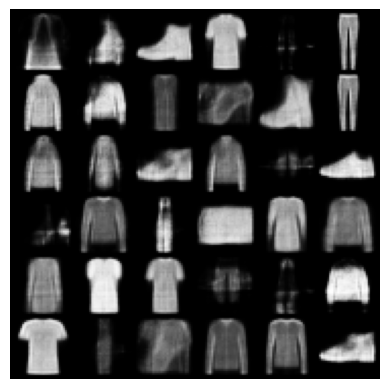

In [ ]:
# Test VAE on a random sample and display on 6X6 grid
grid_size = 6

vae.eval()  # Set the VAE model to evaluation mode

with torch.no_grad():  # No gradient required for visualization
    # batch of latent vectors
    samples = torch.randn(grid_size * grid_size, ZDIM).to(device)
    decoded_images = vae.decode(samples)

    # Convert decoded images for visualization
    visual_grid = vutils.make_grid(decoded_images.reshape(grid_size * grid_size, 1, 28, 28), nrow=grid_size, padding=2, normalize=True)

    # Display the grid of reconstructed images
    plt.imshow(visual_grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()

### Visualize the original vs reconstructed images (TODO)

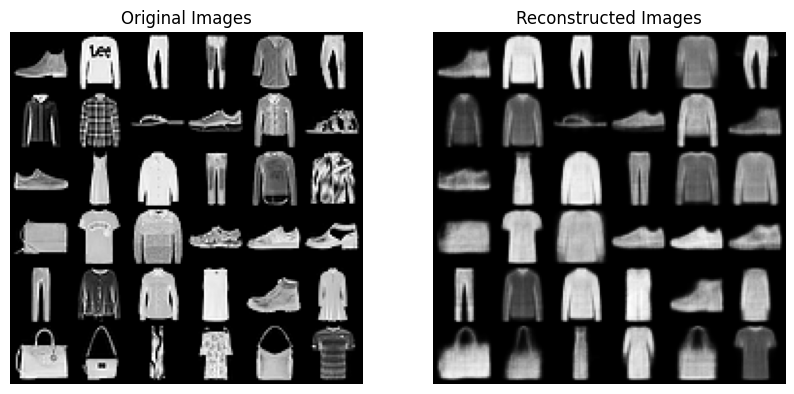

In [ ]:
# Visualise the original vs reconstructed images
# Input the 36 images in Fashion-MNIST to VAE network
# and display reconstructed output on 6X6 grid

vae.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
    for idx, (images, _) in enumerate(test_loader):
        images = images.to(device)
        reconstructions, mu, log_var = vae(images[:36])  # Use only the first 36 samples
        break

    # Make a grid of the original and reconstructed images
    original_images_grid = vutils.make_grid(images[:36], nrow=6, padding=2, normalize=True)
    reconstructed_images_grid = vutils.make_grid(reconstructions.reshape(reconstructions.size(0), 1, 28, 28).cpu(), nrow=6, padding=2, normalize=True)

    # Plot the original images
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.title('Original Images')
    plt.imshow(original_images_grid.cpu().numpy().transpose(1, 2, 0))

    # Plot the reconstructed images
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.title('Reconstructed Images')
    plt.imshow(reconstructed_images_grid.cpu().numpy().transpose(1, 2, 0))

    plt.show()

## Quantitative Evaluation (TODO)

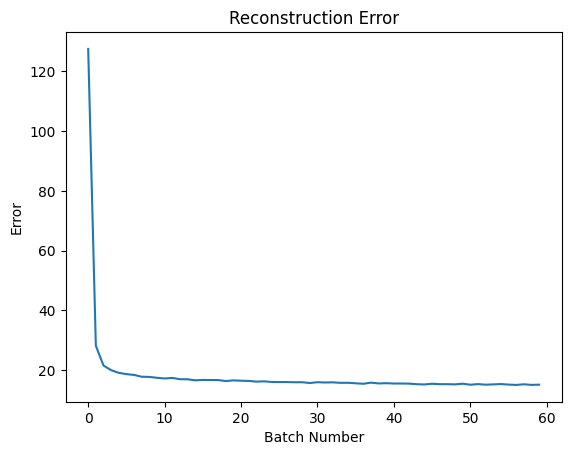

In [ ]:
# Please plot out the reconstruction error curve you saved
# in 'reconstruction_error' list in training.
# And report the final reconstruction error value

errors = [re.cpu().item() for re in reconst_error]

# Plot the reconstruction error
plt.plot(errors)
plt.title("Reconstruction Error")
plt.xlabel("Batch Number")
plt.ylabel("Error")
plt.show()


### VAE IS score

The following block create 2 torch dataset.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_saved = torch.load('/content/vae_{}.pt'.format(num_epochs))
model_vae = VAE(ZDIM)
model_vae.load_state_dict(model_saved['vae'])

# Prepare the torch dataset
evaluate_num = 1000
real_set = []
gen_set = []
test_batch_size = 1
test_dataset = datasets.FashionMNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=True)

for idx, data in enumerate(test_loader, 0):
    model_vae.eval()
    image = data[0]
    # print(image.shape)
    gen_image, _, _ = model_vae(image)

    # print(gen_image.shape)
    gen_image = gen_image.reshape(-1,28,28).unsqueeze(0)
    # print(gen_image.shape)

    image = image.repeat(1,3,1,1)
    gen_image = gen_image.repeat(1,3,1,1)
    real_set.append(image)
    gen_set.append(gen_image)


    if idx == evaluate_num-1:
        break

# make the pytorch dataset
real_set = TensorDataset(torch.cat(real_set))
gen_set = TensorDataset(torch.cat(gen_set))


#### Self-implement IS score (optional TODO)
This optional part is for implementing IS score computation following pdf instructions. You could also use the the next section "IS API" to compute the IS score.
For implementation, you would be asked to implement the most important part "compute_IS" function as an understanding of IS score computation.


In [ ]:
from torchvision.models.inception import inception_v3

def build_feature_table(dataset, model, batch_size, dim, device, upsample):
    '''
    Argms:
    Input:
        dataset: pytorch dataset, you want to evaluate IS score on
        model: Inception network v3
        batch_size: int number
        dim: for IS computation, dim should be 1000 as the final softmax out put dimension
        device: device type torch.device("cuda:0") or torch.device("cpu")
        upsample: Inception network v3 only support input with resolution 299x299
    Output:
        feature_table: (n,dim) numpy matrix
    '''
    # model enter eval mode
    model.eval()
    # initalize the dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    n = len(dataset)
    idx_counter = 0
    # feature table
    feature_table = np.zeros((n, dim))

    for i, data in tqdm.tqdm(enumerate(dataloader, 0)):
        image = data[0].to(device)
        up = nn.Upsample(size=(299, 299), mode='bilinear')
        with torch.no_grad():
            if upsample == True:
                # upsample to 299x299 resolution
                pred = up(image)
            else:
                pred = image
            pred = model(pred)
            # print(pred.shape)
            pred = F.softmax(pred, dim=1).cpu().numpy()

            feature_table[idx_counter:idx_counter+pred.shape[0]] = pred
            idx_counter += len(pred)
        del image
    assert feature_table.shape == (n, dim)
    return feature_table

def compute_IS(feature_table):
    '''
    Argms:
    Input:
        feature_table: (n,dim) numpy matrix
    Output:
        IS_score: float
    '''
    ################################
    # Please fill in your code here:

    ################################
    return IS_score

def IS(dataset, device, upsample=True, batch_size=64, dim=1000):
    '''
    Argms:
    Input:
        dataset: pytorch dataset, you want to evaluate IS score on
        device: device type torch.device("cuda:0") or torch.device("cpu")
        upsample: Inception network v3 only support input with resolution 299x299
        batch_size: int number
        dim: for IS computation, dim should be 1000 as the final softmax out put dimension
    Output:
        IS_score: float
    '''

    # load InveptionV3 model
    model = inception_v3(pretrained=True, transform_input=False).to(device)

    ## build up the feature table
    feature_table = build_feature_table(dataset, model, batch_size, dim, device, upsample)

    ## IS score computation
    IS_score = compute_IS(feature_table)


    return IS_score



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# compute IS score
real_set_IS_score = IS(real_set, device, upsample = True)
gen_set_IS_score = IS(gen_set, device, upsample = True)
print('real images IS_score:', real_set_IS_score)
print('generated images IS_score:', gen_set_IS_score)

#### IS API
Here you could apply the existed API to compute IS score

In [ ]:
from inception_score import inception_score
import warnings
warnings.filterwarnings("ignore")


print('real images IS_score:')
print(inception_score(real_set, cuda=True, batch_size=64, resize=True, splits=1))

print('generated images IS_score:')
print(inception_score(gen_set, cuda=True, batch_size=64, resize=True, splits=1))

real images IS_score:


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 161MB/s] 


(4.225052748478532, 0.0)
generated images IS_score:
(2.8788435851954413, 0.0)


# GAN (please restart you colab session to refresh the GPU memory usage)
### Load data for part 2.1 GAN


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from torch.optim.lr_scheduler import StepLR
import torchvision.utils as vutils
from torch.utils.data import DataLoader, TensorDataset
from scipy import linalg
from scipy.stats import entropy
import tqdm
import cv2
# Resize image to this size
image_size=64

# Setting up transforms to resize and normalize
transform=transforms.Compose([ transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# batchsize of dataset
batch_size = 128

# Load STL-10 Dataset
gan_train_dataset = datasets.STL10(root='./stl10_data/', split='train', transform=transform, download=True)
gan_train_loader = torch.utils.data.DataLoader(dataset=gan_train_dataset, batch_size=batch_size, shuffle=True)

## Model Definition (TODO)

In [ ]:
class DCGAN_Generator(nn.Module):
    def __init__(self):
        super(DCGAN_Generator, self).__init__()

        # Initialize the layers for the generator
        self.layer = self._init_layers()

    def _init_layers(self):
        """Initialize the layers for the generator."""

        # Define a function to create a block of layers
        def block(in_channels, out_channels, kernel_size=(4,4), stride=2, padding=1, final_layer=False):
            """Return a block of layers for the generator."""
            if not final_layer:
                return [
                    nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True)
                ]
            else:
                return [
                    nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                    nn.Tanh()
                ]

        # Create the layers using the block function
        layers = []
        layers.extend(block(in_channels=100, out_channels=1024, stride=1, padding=0))  # Initial block
        layers.extend(block(in_channels=1024, out_channels=512))
        layers.extend(block(in_channels=512, out_channels=256))
        layers.extend(block(in_channels=256, out_channels=128))
        layers.extend(block(in_channels=128, out_channels=3, final_layer=True))  # Final block

        return nn.Sequential(*layers)

    def forward(self, input):
        """Forward pass of the generator."""
        return self.layer(input)


class DCGAN_Discriminator(nn.Module):
    def __init__(self):
        super(DCGAN_Discriminator, self).__init__()

        # Initialize the layers for the discriminator
        self.layer = self._init_layers()

    def _init_layers(self):
        """Initialize the layers for the discriminator."""

        # Define a function to create a block of layers
        def block(in_channels, out_channels, kernel_size=(4,4), stride=2, padding=1, final_layer=False):
            """Return a block of layers for the discriminator."""
            layers = [
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=not final_layer),
                nn.LeakyReLU(0.2, inplace=True)
            ]
            if not final_layer:
                layers.insert(1, nn.BatchNorm2d(out_channels))
            return layers

        # Create the layers using the block function
        layers = []
        layers.extend(block(3, 128, padding=1, final_layer=True))  # Initial block without batchnorm
        layers.extend(block(128, 256))
        layers.extend(block(256, 512))
        layers.extend(block(512, 1024))
        layers.extend([
            nn.Conv2d(1024, 1, kernel_size=(4,4), stride=1, padding=0),
            nn.Sigmoid()
        ])  # Final block to output a single value

        return nn.Sequential(*layers)

    def forward(self, input):
        """Forward pass of the discriminator."""
        return self.layer(input)


## GAN Training

### GAN loss

In [ ]:
fake = torch.load('test_case_GAN/fake.pt')
netD = torch.load('test_case_GAN/netD.pt')
real = torch.load('test_case_GAN/real.pt')
netG = torch.load('test_case_GAN/netG.pt')
noise = torch.load('test_case_GAN/noise.pt')
Valid_label = torch.load('test_case_GAN/Valid_label.pt')
Fake_label = torch.load('test_case_GAN/Fake_label.pt')
criterion = torch.load('test_case_GAN/criterion.pt')

def loss_discriminator(D, real, G, noise, Valid_label, Fake_label, criterion):
    '''
    1. Forward real images into the discriminator
    2. Compute loss between Valid_label and dicriminator output on real images
    3. Forward noise into the generator to get fake images
    4. Forward fake images to the discriminator
    5. Compute loss between Fake_label and discriminator output on fake images
    6. sum real loss and fake loss as the loss_D
    7. we also need to output fake images generate by G(noise) for loss_generator computation
    '''

    def compute_real_loss(D, real, Valid_label, criterion):
        """Compute loss for real images."""
        outputs = D(real).squeeze()
        loss = criterion(outputs, Valid_label)
        return loss

    def compute_fake_loss(D, G, noise, Fake_label, criterion):
        """Compute loss for fake images."""
        fake_images = G(noise)
        outputs = D(fake_images).squeeze()
        loss = criterion(outputs, Fake_label)
        return loss, fake_images

    # Compute losses for real and fake images
    real_loss = compute_real_loss(D, real, Valid_label, criterion)
    fake_loss, fake_images = compute_fake_loss(D, G, noise, Fake_label, criterion)

    # Sum the losses
    total_loss = real_loss + fake_loss

    return total_loss, fake_images

def loss_generator(netD, fake, Valid_label, criterion):
    '''
    1. Forward fake images to the discriminator
    2. Compute loss between valid labels and discriminator output on fake images
    '''
    # Fwd Fake images to D
    fake_D = netD(fake).squeeze()

    # Loss between Valid Labels and D
    loss_G = criterion(fake_D, Valid_label)
    return loss_G


loss_D, fake_G = loss_discriminator(netD, real, netG, noise, Valid_label, Fake_label, criterion)
torch.save(loss_D, 'test_case_GAN/loss_D.pt')
loss_G = loss_generator(netD, fake, Valid_label, criterion)
torch.save(loss_G, 'test_case_GAN/loss_G.pt')


test_loss_D = torch.load('test_case_GAN/loss_D.pt')
test_loss_G = torch.load('test_case_GAN/loss_G.pt')

print('test case loss_D:', test_loss_D.item())
print('computed loss_D:', loss_D.item())

print('test case loss_G:', test_loss_G.item())
print('computed loss_G:', loss_G.item())


test case loss_D: 1.3626351356506348
computed loss_D: 1.3626351356506348
test case loss_G: 0.7321602702140808
computed loss_G: 0.7321602702140808


### Training block

[0/100][0/40]	Loss_D: 1.3876	Loss_G: 0.8155	
[1/100][0/40]	Loss_D: 0.0627	Loss_G: 3.8088	
[2/100][0/40]	Loss_D: 1.6445	Loss_G: 4.9419	
[3/100][0/40]	Loss_D: 0.1526	Loss_G: 4.6841	
[4/100][0/40]	Loss_D: 0.0416	Loss_G: 5.1803	
[5/100][0/40]	Loss_D: 0.6252	Loss_G: 4.0954	
[6/100][0/40]	Loss_D: 0.2778	Loss_G: 3.7765	
[7/100][0/40]	Loss_D: 1.7317	Loss_G: 7.0706	
[8/100][0/40]	Loss_D: 0.3463	Loss_G: 3.3765	
[9/100][0/40]	Loss_D: 0.5474	Loss_G: 3.3842	
[10/100][0/40]	Loss_D: 0.3734	Loss_G: 2.8369	
[11/100][0/40]	Loss_D: 0.3421	Loss_G: 5.3949	
[12/100][0/40]	Loss_D: 1.1673	Loss_G: 2.2610	
[13/100][0/40]	Loss_D: 0.4112	Loss_G: 4.8897	
[14/100][0/40]	Loss_D: 0.5119	Loss_G: 4.9331	
[15/100][0/40]	Loss_D: 0.4335	Loss_G: 4.0954	
[16/100][0/40]	Loss_D: 2.5034	Loss_G: 4.2124	
[17/100][0/40]	Loss_D: 0.8367	Loss_G: 2.0766	
[18/100][0/40]	Loss_D: 0.8613	Loss_G: 3.9955	
[19/100][0/40]	Loss_D: 0.9133	Loss_G: 6.1816	
[20/100][0/40]	Loss_D: 2.4068	Loss_G: 1.3604	
[21/100][0/40]	Loss_D: 0.9619	Loss_G: 5.6089

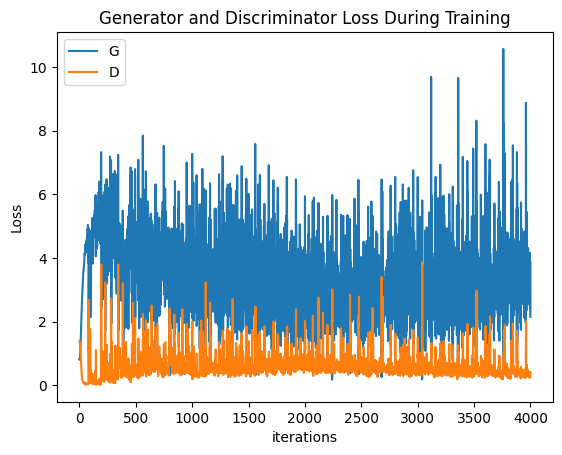

In [ ]:
import torchvision.utils as vutils
from torch.optim.lr_scheduler import StepLR
import pdb

device = torch.device("mps")

# Number of channels
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 128
# Size of feature maps in discriminator
ndf = 128


# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Create the generator and discriminator
netG = DCGAN_Generator().to(device)
netD = DCGAN_Discriminator().to(device)

# Apply weight initialization
netG.apply(weights_init)
netD.apply(weights_init)


# Initialize BCELoss function
criterion = nn.BCELoss()

# Create latent vector to test the generator performance
fixed_noise = torch.randn(36, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

learning_rate = 0.0002
beta1 = 0.5

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))

img_list = []
real_img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 100


def load_param(num_eps):
  model_saved = torch.load('/content/gan_{}.pt'.format(num_eps))
  netG.load_state_dict(model_saved['netG'])
  netD.load_state_dict(model_saved['netD'])

# GAN Training Loop
for epoch in range(num_epochs):
    for i, data in enumerate(gan_train_loader, 0):
        real = data[0].to(device)
        b_size = real.size(0)
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        Valid_label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        Fake_label = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        netD.zero_grad()
        # Function to compute discriminator loss
        loss_D, fake = loss_discriminator(netD, real, netG, noise, Valid_label, Fake_label, criterion)


        # torch.save(fake,'test_case_GAN/fake.pt')
        # torch.save(netD,'test_case_GAN/netD.pt')
        # torch.save(real,'test_case_GAN/real.pt')
        # torch.save(netG,'test_case_GAN/netG.pt')
        # torch.save(noise,'test_case_GAN/noise.pt')
        # torch.save(Valid_label,'test_case_GAN/Valid_label.pt')
        # torch.save(Fake_label,'test_case_GAN/Fake_label.pt')
        # torch.save(criterion,'test_case_GAN/criterion.pt')

        # pdb.set_trace()

        loss_D.backward(retain_graph=True)
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        # Function to compute generator loss
        loss_G = loss_generator(netD, fake, Valid_label, criterion)
        # Calculate gradients for G
        loss_G.backward(retain_graph=True)
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t'
                  % (epoch, num_epochs, i, len(gan_train_loader),
                     loss_D.item(), loss_G.item()))

        # Save Losses for plotting later
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(gan_train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

        if epoch % 15 == 0:
            checkpoint = {'netG': netG.state_dict(), 'netD': netD.state_dict()}
            torch.save(checkpoint, 'models/gan_{}.pt'.format(epoch))



plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

checkpoint = {'netG': netG.state_dict(),
              'netD': netD.state_dict()}
torch.save(checkpoint, 'content/gan_{}.pt'.format(num_epochs))


## Qualitative Visualisations

### GAN Testing (TODO)

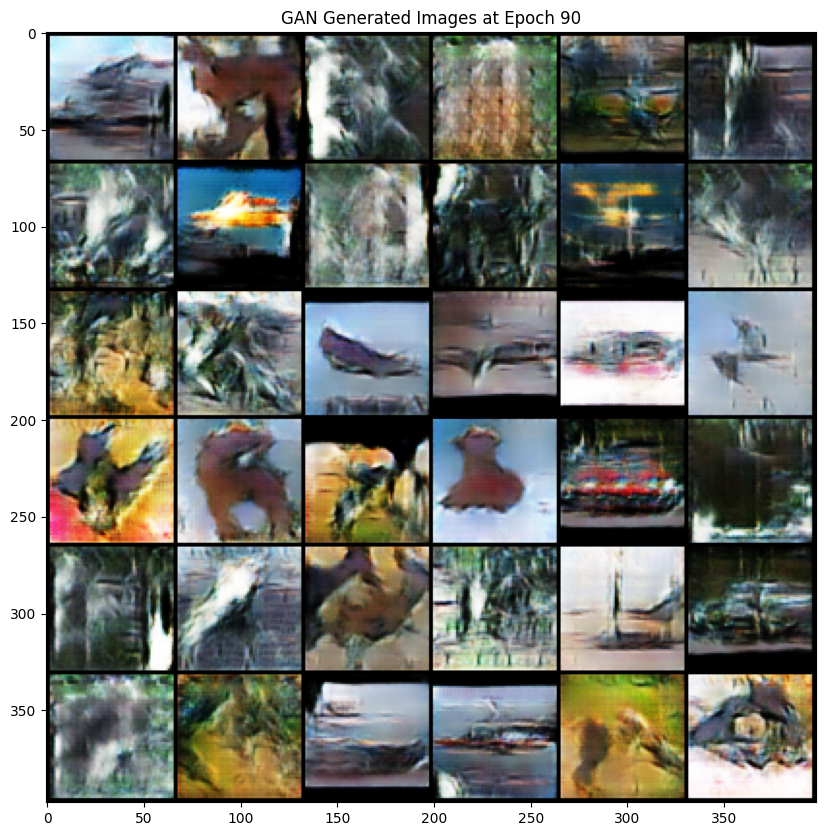

In [ ]:
# Test GAN on a random sample and display on 6X6 grid

# Load the specified GAN model checkpoint.
def load_gan_checkpoint(epoch_number):
    # Load the model saved at the specified epoch.
    model_checkpoint = torch.load(f'/content/models/gan_{epoch_number}.pt', map_location=torch.device('cuda:0'))
    # Update the Generator and Discriminator networks with the loaded state.
    netG.load_state_dict(model_checkpoint['netG'])
    netD.load_state_dict(model_checkpoint['netD'])


# Number of epochs the model was trained for.
trained_epochs = 90

# Test the GAN model with one set of generated images.
def test_gan_model(trained_epochs):
    """
    Test the GAN model by generating and displaying a grid of images.

    Args:
    trained_epochs (int): The number of epochs the model was trained for.

    Returns:
    None
    """
    # Load model parameters from the specified epoch.
    load_gan_checkpoint(trained_epochs)

    # Generate images without tracking gradients for efficiency.
    with torch.no_grad():
        # Define batch size and generate latent variables.
        batch_size = 36
        latent_variables = torch.randn(batch_size, nz, 1, 1, device=device)
        # Generate images using the Generator network.
        generated_images = netG(latent_variables)
        # Arrange images in a 6x6 grid.
        image_grid = vutils.make_grid(generated_images, nrow=6, normalize=True)

        # Display the grid of generated images.
        plt.figure(figsize=(10,10))
        plt.imshow(image_grid.cpu().numpy().transpose(1, 2, 0))
        plt.title("GAN Generated Images at Epoch " + str(trained_epochs))
        plt.show()

# Run the test function for the GAN model.
test_gan_model(trained_epochs)

### Visualisation at different epochs (TODO)

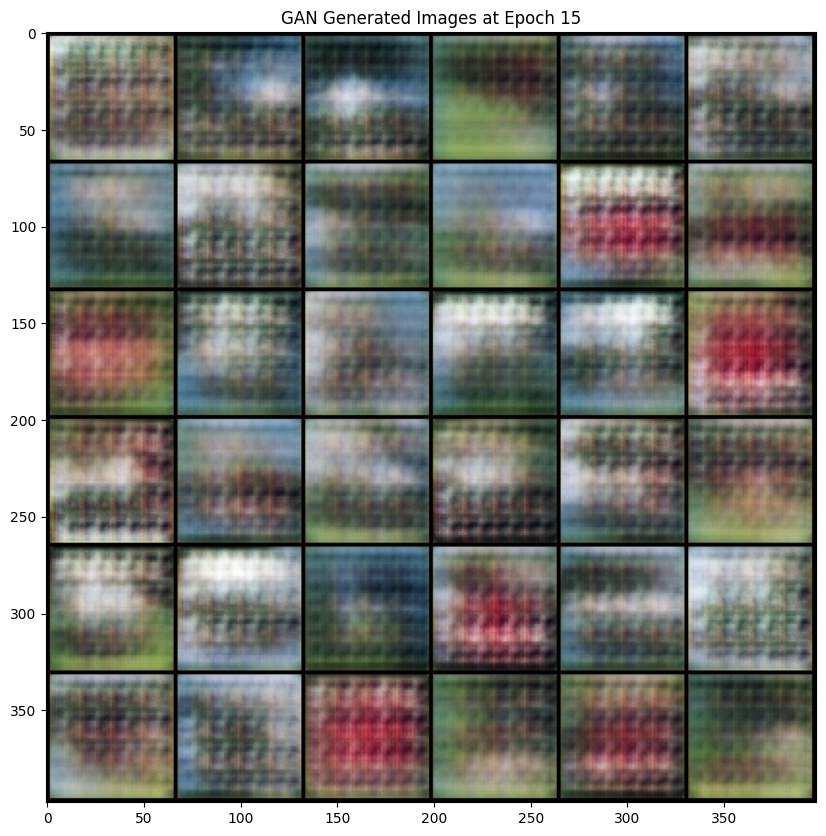

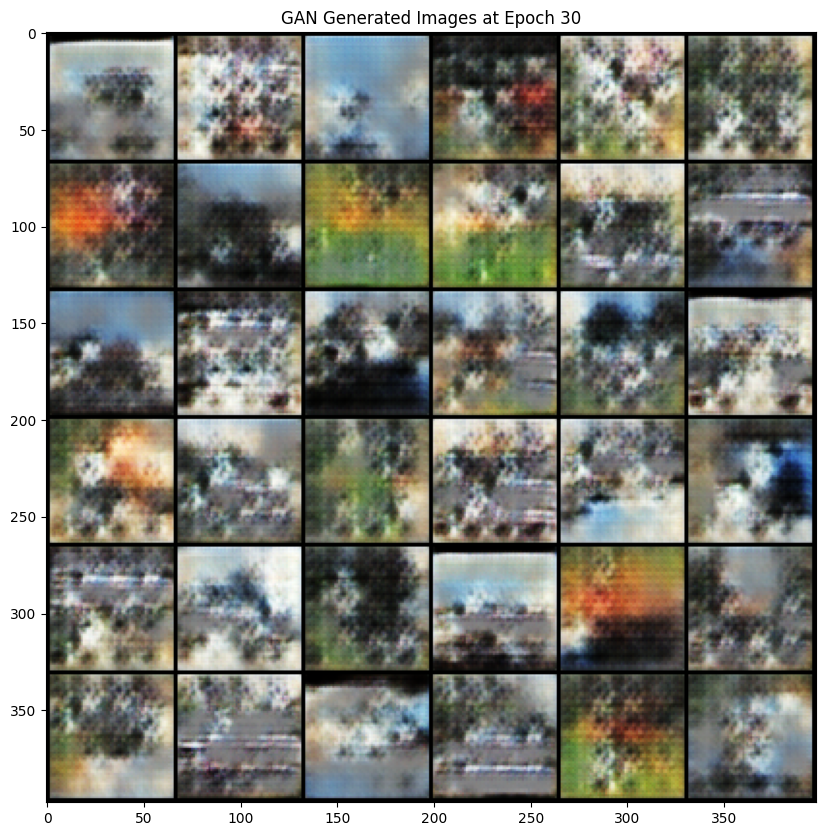

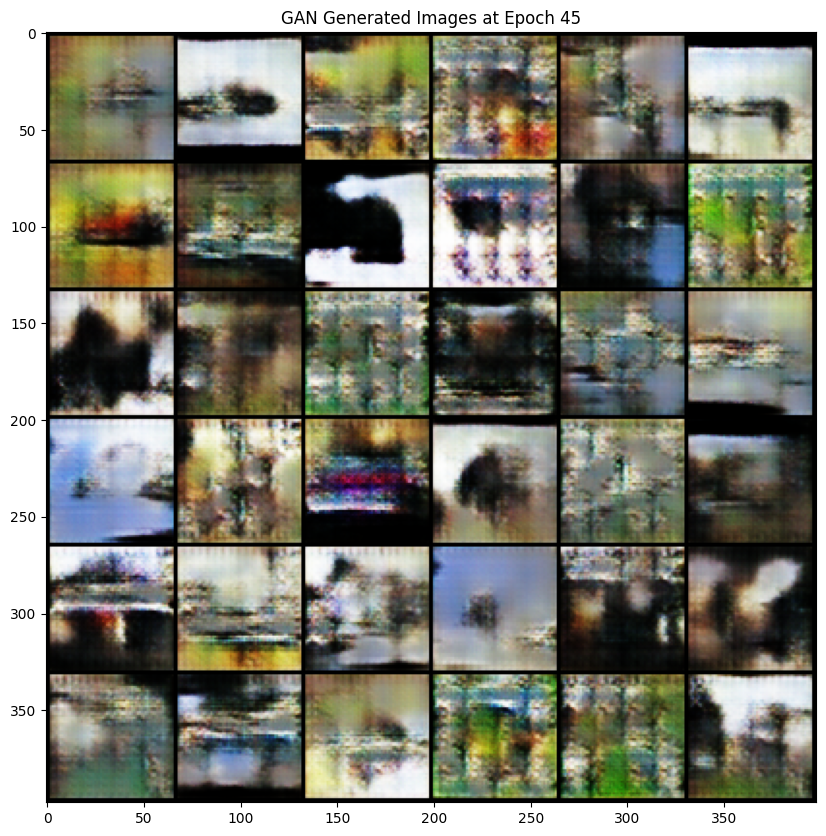

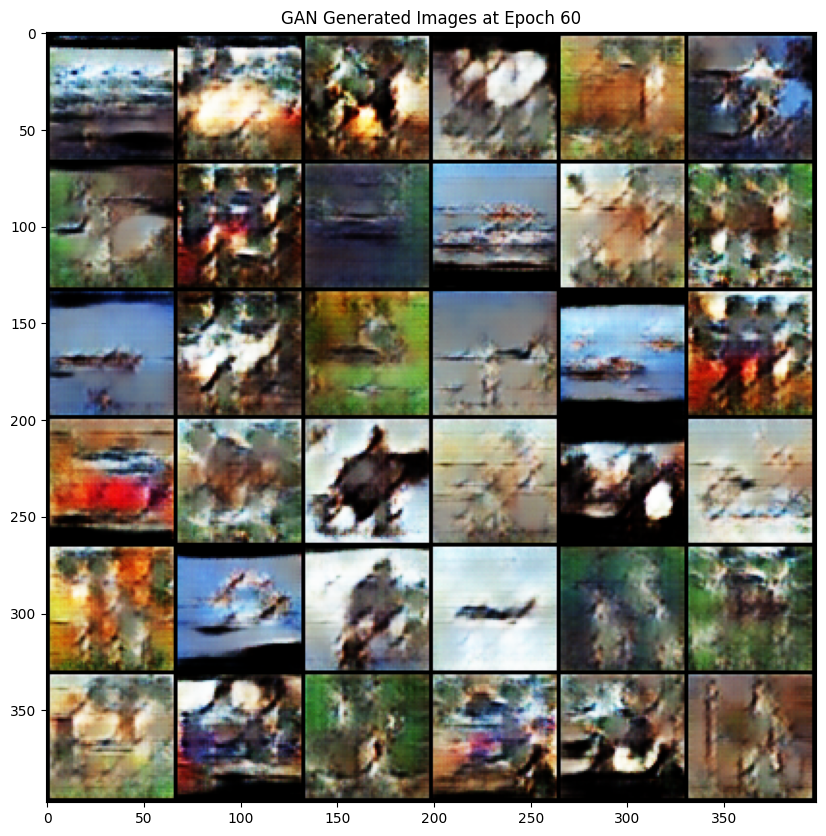

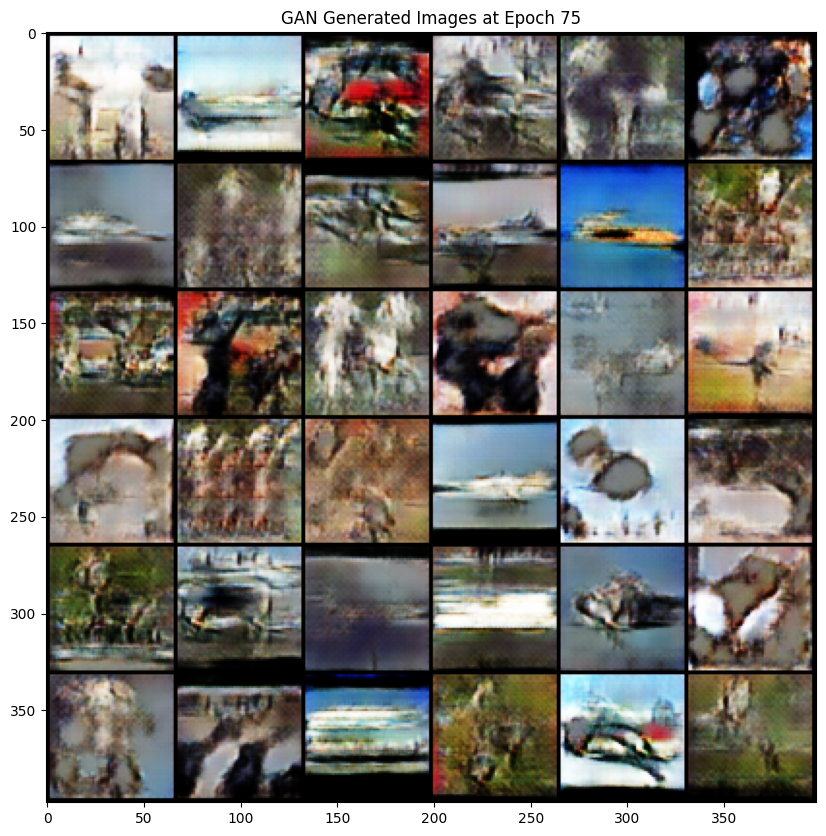

In [ ]:
# Plot GAN generated images at different epochs during training
for epoch in [15, 30, 45, 60, 75]:
    test_gan_model(epoch)

## Quantitative Evaluation

In [ ]:
# Resize image to this size
image_size=64

# Setting up transforms to resize and normalize
transform=transforms.Compose([ transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Load STL-10 test set
test_batch_size = 1
gan_test_dataset = datasets.STL10(root='./stl10_data/', split='test', transform=transform, download=True)
gan_test_loader = torch.utils.data.DataLoader(dataset=gan_test_dataset, batch_size=test_batch_size, shuffle=False)

100%|██████████| 2640397119/2640397119 [06:23<00:00, 6886528.03it/s]


Extracting ./stl10_data/stl10_binary.tar.gz to ./stl10_data/


### FID score for GAN
This part, you would be asked to compute a FID score between the real image and the generated images to evaluate the photo-realistic quality of the generated images.
For this part, we should create three folder:
- 1. STL_10_real_1
- 2. STL_10_real_2
- 3. STL_10_fake


In [29]:
! mkdir STL_10_fake STL_10_real_1 STL_10_real_2

Create the dataset to evaluate quantitative scores.

In [30]:

# Number of channels
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 128
# Size of feature maps in discriminator
ndf = 128
# Load checkpoint
model_saved = torch.load('models/gan_{}.pt'.format(90), map_location=device)
netG = DCGAN_Generator()
netG.load_state_dict(model_saved['netG'])
netG.to(device)


def denorm(x, norm_mean, norm_std):
    y = torch.zeros(x.shape)
    y[:,0,:,:] = x[:,0,:,:]*norm_std[0] + norm_mean[0]
    y[:,1,:,:] = x[:,1,:,:]*norm_std[1] + norm_mean[1]
    y[:,2,:,:] = x[:,2,:,:]*norm_std[2] + norm_mean[2]
    return y

evaluate_num = 1000

# make the gen data set and folder
gen_set = []
for idx in range(evaluate_num):
    with torch.no_grad():
        fixed_noise = torch.randn(1, nz, 1, 1, device=device)
        fake = netG(fixed_noise).detach().cpu()
        fake = fake.cpu().detach()
        fake_denorm = denorm(fake, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        # print(fake_denorm.shape)
        gen_set.append(fake_denorm)

        # plt.imshow(np.transpose(vutils.make_grid(fake, nrow=6 ,padding=2, normalize=True),(1,2,0)), animated=True)
        save_image(fake.squeeze(), './STL_10_fake/fake' + str(idx) + '.png', normalize=True)

gen_dataset = TensorDataset(torch.cat(gen_set))

# make the real data set and folder
real_set_1 = []
real_set_2 = []

for idx, data in enumerate(gan_test_loader, 0):
    image = data[0]
    # print(image.shape)
    image_denorm = denorm(image, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    if idx < evaluate_num:
        real_set_1.append(image_denorm)
        save_image(image.squeeze(), './STL_10_real_1/real' + str(idx) + '.png', normalize=True)
    elif evaluate_num <= idx < 2*evaluate_num:
        real_set_2.append(image_denorm)
        save_image(image.squeeze(), './STL_10_real_2/real' + str(idx) + '.png', normalize=True)
    if idx == 2*evaluate_num-1:
        break

# make the pytorch dataset
real_dataset_1 = TensorDataset(torch.cat(real_set_1))
real_dataset_2 = TensorDataset(torch.cat(real_set_2))

#### Self-implement FID score (optional TODO)
This optional part is for implementing FID score computation following pdf instructions. Implement "compute_FID" function which is the most important part in FID score computation. You could also use the the next section "FID API" to compute the FID score.

In [24]:
! pip install pytorch-fid
from pytorch_fid.inception import InceptionV3

def build_feature_table(dataset, model, batch_size, dim, device):
    '''
    Argms:
    Input:
        dataset: pytorch dataset, you want to evaluate IS score on
        model: Inception network v3
        batch_size: int number
        dim: for IS computation, dim should be 1000 as the final softmax out put dimension
        device: device type torch.device("cuda:0") or torch.device("cpu")
    Output:
        feature_table: (n,dim) numpy matrix
    '''
    # model enter eval mode
    model.eval()
    # initalize the dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    n = len(dataset)
    idx_counter = 0
    # feature table
    feature_table = np.zeros((n, dim))

    for i, data in tqdm.tqdm(enumerate(dataloader, 0)):
        image = data[0].to(device)

        with torch.no_grad():
            pred = model(image)[0]
            pred = pred.squeeze(3).squeeze(2).cpu().numpy()
            feature_table[idx_counter:idx_counter+pred.shape[0]] = pred
            idx_counter += len(pred)

    return feature_table

def compute_stat(feature_table):
    '''
    Argms:
    Input:
        feature_table: (n,dim) numpy matrix
    Output:
        mu: mean along row dimension
        sigma: covarance matrix of dataset
    '''
    # compute mean and sigma based on activation table
    mu = np.mean(feature_table, axis=0)
    sigma = np.cov(feature_table, rowvar=False)

    # print('dimension of mu', mu.shape)
    # print('dimension of sigma', sigma.shape)
    return mu, sigma

def compute_FID(mu_1, sigma_1, mu_2, sigma_2, eps=1e-6):
    '''
    Argms:
    Input:
        mu_1: mean vector we get for dataset1
        sigma_1: covariance matrix for dataset1
        mu_2: mean vector we get for dataset2
        sigma_2: covariance matrix for dataset1
    Output:
        FID score: float
    '''

    # compute mu difference

    # compute square root of Sigma1*Sigma2 using "linalg.sqrtm" from scipy
    # please name the resulting matrix as covmean
    covmean = linalg.sqrtm(sigma_1 @ sigma_2)

    # The following block take care of imagionary part of covmean
    #################################################################
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma_1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma_1 + offset).dot(sigma_2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real
    #################################################################

    # compute FID score, based on eqution.(10) in pdf FID part.
    squared_norm_diff = np.linalg.norm(mu_1 - mu_2) ** 2
    trace_term = np.trace(sigma_1 + sigma_2 - 2 * covmean)
    return squared_norm_diff + trace_term

def FID(dataset_1, dataset_2, device, batch_size=64, dim=2048, block_idx = 3):
    '''
    Argms:
    Input:
        dataset_1: pytorch dataset
        dataset_2: pytorch dataset
        device: device type torch.device("cuda:0") or torch.device("cpu")
        batch_size: int number
        dim: for IS computation, dim should be 1000 as the final softmax out put dimension
        block_idx: the block stage index we want to use in inception module
    Output:
        FID_score: float
    '''
    # load InveptionV3 model
    model = InceptionV3([block_idx]).to(device)

    ## build up the feature table
    feature_table_1 = build_feature_table(dataset_1, model, batch_size, dim, device)
    feature_table_2 = build_feature_table(dataset_2, model, batch_size, dim, device)


    ## compute mu, sigma for dataset 1&2
    mu_1, sigma_1 = compute_stat(feature_table_1)
    mu_2, sigma_2 = compute_stat(feature_table_2)


    ## FID score computation
    FID_score = compute_FID(mu_1, sigma_1, mu_2, sigma_2, eps=1e-6)


    return FID_score


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# compute FID using FID function you implemented above
FID_score = FID(real_dataset_1, real_dataset_1, device)
print('FID_score between real_dataset_1 and itself:', FID_score)

FID_score = FID(real_dataset_1, real_dataset_2, device)
print('FID_score between real_dataset_1 and real_dataset_2:', FID_score)

FID_score = FID(real_dataset_1, gen_dataset, device)
print('FID_score between real_dataset_1 and generated image set:', FID_score)

16it [00:11,  1.43it/s]
16it [00:10,  1.54it/s]


FID_score between real_dataset_1 and itself: -2.19349562035117e-05


16it [00:09,  1.71it/s]
16it [00:09,  1.77it/s]


FID_score between real_dataset_1 and real_dataset_2: 37.661986424674716


16it [00:10,  1.58it/s]
16it [00:09,  1.65it/s]


FID_score between real_dataset_1 and generated image set: 211.1462516496826


#### FID API

In [25]:
! pip install pytorch-fid
! python -m pytorch_fid 'STL_10_real_1' 'STL_10_real_1'
! python -m pytorch_fid 'STL_10_real_1' 'STL_10_real_2'
! python -m pytorch_fid 'STL_10_real_1' 'STL_10_fake'


Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/pytorch_fid/__main__.py", line 3, in <module>
    pytorch_fid.fid_score.main()
  File "/usr/local/lib/python3.10/dist-packages/pytorch_fid/fid_score.py", line 313, in main
    fid_value = calculate_fid_given_paths(args.path,
  File "/usr/local/lib/python3.10/dist-packages/pytorch_fid/fid_score.py", line 253, in calculate_fid_given_paths
    raise RuntimeError('Invalid path: %s' % p)
RuntimeError: Invalid path: STL_10_real_1
Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist

If you implement the self-implement FID version. You would notice a negligible difference in value. Because the API package compute this value by saving and reading tensor from .png files. Accuracy problem could happen in the middle of transation.

### IS score for GAN

#### Self-implement IS score (optional)

<!-- You could copy and paste this function from VAE part if you have implement that part. -->


In [ ]:
from torchvision.models.inception import inception_v3

def build_feature_table(dataset, model, batch_size, dim, device, upsample):
    '''
    Argms:
    Input:
        dataset: pytorch dataset, you want to evaluate IS score on
        model: Inception network v3
        batch_size: int number
        dim: for IS computation, dim should be 1000 as the final softmax out put dimension
        device: device type torch.device("cuda:0") or torch.device("cpu")
        upsample: Inception network v3 only support input with resolution 299x299
    Output:
        feature_table: (n,dim) numpy matrix
    '''
    # model enter eval mode
    model.eval()
    # initalize the dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    n = len(dataset)
    idx_counter = 0
    # feature table
    feature_table = np.zeros((n, dim))

    for i, data in tqdm.tqdm(enumerate(dataloader, 0)):
        image = data[0].to(device)
        up = nn.Upsample(size=(299, 299), mode='bilinear')
        with torch.no_grad():
            if upsample == True:
                # upsample to 299x299 resolution
                pred = up(image)
            pred = model(pred)
            # print(pred.shape)
            pred = F.softmax(pred, dim=1).cpu().numpy()

            feature_table[idx_counter:idx_counter+pred.shape[0]] = pred
            idx_counter += len(pred)
    assert feature_table.shape == (n, dim)
    return feature_table

def compute_IS(feature_table):
    '''
    Argms:
    Input:
        feature_table: (n,dim) numpy matrix
    Output:
        IS_score: float
    '''
    ################################
    # Please fill in your code here:

    ################################
    return IS_score

def IS(dataset, device, upsample=True, batch_size=64, dim=1000):
    '''
    Argms:
    Input:
        dataset: pytorch dataset, you want to evaluate IS score on
        device: device type torch.device("cuda:0") or torch.device("cpu")
        upsample: Inception network v3 only support input with resolution 299x299
        batch_size: int number
        dim: for IS computation, dim should be 1000 as the final softmax out put dimension
    Output:
        IS_score: float
    '''

    # load InveptionV3 model
    model = inception_v3(pretrained=True, transform_input=False).to(device)

    ## build up the feature table
    feature_table = build_feature_table(dataset, model, batch_size, dim, device, upsample)

    ## IS score computation
    IS_score = compute_IS(feature_table)


    return IS_score



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# compute IS score
real_set_IS_score = IS(real_dataset_1, device, upsample = True)
gen_set_IS_score = IS(gen_dataset, device, upsample = True)
print('real images IS_score:', real_set_IS_score)
print('generated images IS_score:', gen_set_IS_score)

#### IS API

In [31]:
from inception_score import inception_score
import warnings
warnings.filterwarnings("ignore")

print('IS score for real data set 1:')
print(inception_score(real_dataset_1, cuda=True, batch_size=64, resize=True, splits=1))
print('IS score for generated data set:')
print(inception_score(gen_dataset, cuda=True, batch_size=64, resize=True, splits=1))

IS score for real data set 1:


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 149MB/s] 


(14.623364188788035, 0.0)
IS score for generated data set:
(2.614723636293825, 0.0)
